In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_theme(style="darkgrid")

# Transformer with Intent

In [12]:
from parksim.trajectory_predict.intent_transformer.network import TrajectoryPredictorWithIntent
from parksim.trajectory_predict.intent_transformer.dataset import IntentTransformerDataset

In [3]:
def build_trajectory_predict_from_config(config, input_shape=(3, 100, 100)):
    model = TrajectoryPredictorWithIntent(
        input_shape=input_shape,
        dropout=config['dropout'], 
        num_heads=config['num_heads'], 
        num_encoder_layers=config['num_encoder_layers'], 
        num_decoder_layers=config['num_decoder_layers'], 
        dim_model=config['dim_model'],
        d_hidden=config['d_hidden'],
        num_conv_layers=config['num_conv_layers']
    )
    return model

In [4]:
dataset_nums = ["../data/DJI_" + str(i).zfill(4) for i in range(22, 23)]
#seed=42
#val_proportion = 0.1
dataset = IntentTransformerDataset(dataset_nums, img_transform=transforms.ToTensor())
#val_size = int(val_proportion * len(dataset))
#train_size = len(dataset) - val_size
#validation_dataset, _ = torch.utils.data.random_split(dataset, [val_size, train_size], generator=torch.Generator().manual_seed(seed))
dataloader = DataLoader(dataset, batch_size=32, num_workers=1)
loss_fn = nn.L1Loss(reduction='none').to(DEVICE)


In [5]:
model_paths = {"all": {
    "path": "models/Trajectory-Intent-4-10-22.pth",
    "config" : {
            'dim_model' : 52,
            'num_heads' : 4,
            'dropout' : 0.15,
            'num_encoder_layers' : 16,
            'num_decoder_layers' : 8,
            'd_hidden' : 256,
            'num_conv_layers' : 2,
            'opt' : 'SGD',
            'lr' : 0.0025,
            'loss' : 'L2'
        }

    }}


In [9]:


def predict(model, input_sequence, img, intent, y_in, output_sequence_length):
    model.eval()
    START_TOKEN = input_sequence[0, -1]

    delta_state = -1 * input_sequence[:, -2]
    y_input = torch.concat([START_TOKEN, delta_state], dim=1)
    #y_input = START_TOKEN[None,None,:].repeat(input_sequence.shape[0], 1, 1)
    for _ in range(output_sequence_length):
        # Get source mask
        tgt_mask = model.transformer.generate_square_subsequent_mask(y_input.size(1)).to(DEVICE).float()
        pred = model(img, input_sequence, intent, y_input, tgt_mask)
        #pred = pred.permute(1, 0, 2)
        #print(pred)
        next_item = pred[:, -1][:, None, :]
        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)
    return y_input[:,1:]

def get_error_vs_time(model, dataloader, loss_fn, feature_size=3, steps=10):
    model.eval()

    pos_error = torch.empty(size=(feature_size, steps)).to(DEVICE)
    ang_error = torch.empty(size=(feature_size, steps)).to(DEVICE)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            img, X, intent, y_in, y_label = batch
            img = img.to(DEVICE).float()
            X = X.to(DEVICE).float()
            intent = intent.to(DEVICE).float()
            y_in = y_in.to(DEVICE).float()
            y_label = y_label.to(DEVICE).float()
            tgt_mask = model.transformer.generate_square_subsequent_mask(
                y_in.shape[1]).to(DEVICE).float()
            #pred = model(img, X, intent, y_in, tgt_mask)
            pred = predict(model, X, img, intent, y_in, 9)
            #pred2 = model(img, X, intent, y_in, tgt_mask)[:, :1]
            loss = loss_fn(pred, y_label)

            pos_error = torch.cat(
                [pos_error, torch.sqrt(loss[:, :, 0]**2 + loss[:, :, 1]**2).detach()])
            ang_error = torch.cat([ang_error, loss[:, :, 2].detach()])

    return pos_error.cpu().numpy(), ang_error.cpu().numpy()


In [10]:
all_error = []
dt = 0.4

for name, model_info in model_paths.items():
    print(f'Getting statistics for model {name}')

    model = build_trajectory_predict_from_config(model_info['config'])
    model_state = torch.load(model_info['path'], map_location=DEVICE)
    model.load_state_dict(model_state)
    model.eval().to(DEVICE)

    pos_error, ang_error = get_error_vs_time(model, dataloader, loss_fn, steps=10)

    timesteps = dt*np.arange(1, pos_error.shape[1]+1)
    for i, time in enumerate(timesteps):
        for error in pos_error[:, i]:
            all_error.append([name, time, 'Positional', error])
        for error in ang_error[:, i]:
            all_error.append([name, time, 'Angular', error])

error_df = pd.DataFrame(
    all_error, columns=['Epoch', 'Timestep', 'Type', 'Error'])
error_df = error_df[abs(error_df['Error']) < 100] # Outlier removal
error_df['Epoch'] = pd.Categorical(error_df.Epoch)
error_df['Type'] = pd.Categorical(error_df.Type)

Getting statistics for model all


  0%|          | 0/275 [00:05<?, ?it/s]

KeyboardInterrupt



Text(0.5, 1.0, 'Angular Error (rad)')

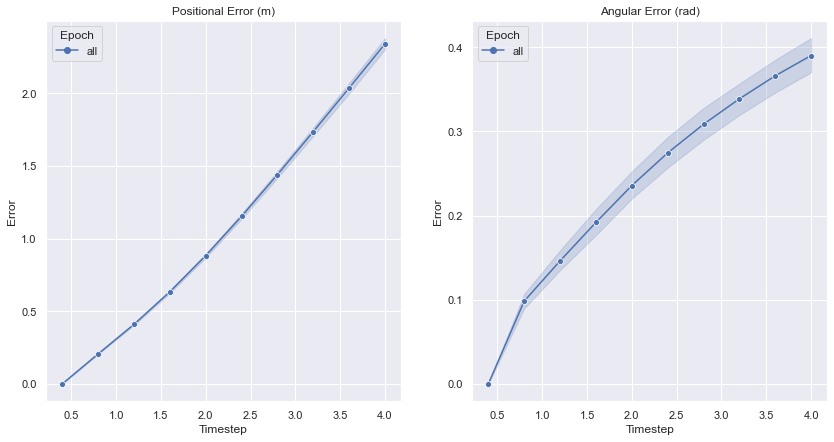

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(x="Timestep", y="Error", hue="Epoch", ci=95, style="Epoch",
             markers=True, dashes=False, data=error_df[error_df["Type"] == "Positional"], ax=axes[0])
sns.lineplot(x="Timestep", y="Error", hue="Epoch", ci=95, style="Epoch",
             markers=True, dashes=False, data=error_df[error_df["Type"] == "Angular"], ax=axes[1])

axes[0].set_title('Positional Error (m)')
axes[1].set_title('Angular Error (rad)')